# Explainer Notebook

**Don't run this notebook - find the full versions of our code in the download section of the website** 


The Notebook will contain all the behind the scenes stuff, details on the dataset, why we've selected this particular dataset, explanations of our choices regarding network analysis, etc. This notebook was written by:
 - Nermen Ghoniem
 - Elena Alexandra
 - Margarita Genova


# I. Motivation 

- ## **What is your dataset?**<br>
We have chosen to collect data from the Marvel universe. The data was collected from various sites, such as:
     - Network analysis:
          - We will be using the wikia API to extract the information needed from http://marvel.wikia.com/wiki - we don’t download the files locally. In this part, we have focused on the website categories “Characters” and  “Characters By Nationality”.
     - Sentiment analysis:
         - We will be using a combination of the website category “Transcripts” from http://marvel.wikia.com/wiki along with http://fullmovietext.com to extract the transcripts needed.

***Description of dataset:***
<br><br>
We have collected 10000 characters from the Marvel Universe. For each character we have also collected their wikia page and which nationality they belong to (for community detection). This data was accessible by parsing the relevant web pages at http://marvel.wikia.com/wiki.
<br><br>
This resulted in a Python dictionary containing 10000 characters from the Marvel universe. Each entry in the dictionary contains two elements.
<br><br>
<dl>
<dt></dt>
<dd>1. The character ID of the character </dd>
<dt></dt>
<dd>2. The name of the nationality that the character is affiliated with. </dd>
<dd>3. A set of links from the character's wikia page.</dd>
</dl>
Furthermore, we have retrieved and created another dictionary containing information on the different nationalities in the Marvel Universe. An entry has the name of the nationality as key and a list of the members of this nationality as value.

- ## **Why did you choose this/these particular dataset(s)?**<br><br>
Originally, we wanted to look into the Powerpuff girls and find their hidden sister by detecting the closest neighbour to their wikipedia page in a network of female animated characters. However, whilst performing the pre-analysis, we observed that a predominant amount of wikipedia articles on this topic were from the Marvel and DC universe.
<br><br>
This sparked our curiosity to look further into these universes instead. Our decision to go forward with the Marvel universe only was due to the immense amount of data available there. Furthermore, Stan Lee died recently and to honour him - we are going to pay homage to his complex and internationally diverse network of characters with this report.

- ## **What was your goal for the end user's experience?**<br><br>
The initial goal was inspired by the idea of a map of the world plotting out Marvel characters. Therefore, with this idea in mind, we decided to use the website categories “Characters” and  “Characters By Nationality” to find out the roots of the beloved comic book characters from the Marvel Universe and investigate how community-like the comic book characters are with regards to their nationalities.
<br><br>
Yet, it’s impossible to mention the comic book character without discussing the Marvel Cinematic Universe. Therefore, we wanted to conduct some sentiment analysis of film transcripts showcasing interesting characters that we have identified in our network analysis. Thereby, we formulated the following problem statement:
<br><br>
*In a network of the Marvel Universe’s comic book characters, how assortative are the comic book characters with respect to degree, nationalities and communities? And, how do the comic book characters with highest total degree in the network perform in the Marvel Cinematic Universe?*


# II. Basic stats. Let's understand the dataset better 

- ## **Write about your choices in data cleaning and preprocessing**<br><br>
When we retrieve the wikia page of each character, we use the BeautifulSoup library to get the HTML page. Since we only need a fraction of the page, everything else is filtered out. The remaining part of the page is also cleaned, as we are only interested in the internal links on the page, and the nationality information (if it's present for the given character).
<br><br>
When we retrieve the transcripts of each Avengers movie from the wikia category and fullmovietext.com, we are also using BeautifulSoup to get the HTML page. The text went through a cleaning process, so we scraped the relevant information by looking for a unique class pertaining to the body of the site.
<br><br>
Thereafter, the text was tokenized as well as cleaned from stop words and punctuation. Afterwards, the text was sent through a TF-IDF process and used to generate the word clouds.
<br><br>
- ## **Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)**<br><br>
    - The dataset contains 10000 characters, with 187 nations represented.
    - Out of 10000 characters, 2154 characters don’t have the nationality information present on their wikia page.
    - Out of the remaining 7846 characters, 3668 were isolated nodes in the network, as they did not link to other characters.
    - In a network of 4178 characters (nodes), there were 5657 internal links (edges). The character with most links is Anthony Stark (Iron Man) and has 362 links.

# III. Tools, theory and analysis

## Network analysis<br><br>
We will perform a network analysis on the network of  comic book characters from the Marvel Universe. We decided to focus on the first 10.000 characters, sorted from A to Z. For each character we collected their wikia page and which nationality they belong to (for community detection). This data was accessible by parsing the relevant web pages at http://marvel.wikia.com/. Below, we will describe the methods used:

With ***getCharacters()*** function, we retrieve 10 000 characters from the Marvel wikia page. For every character, we save his ID, nationality and set of all of their links in a dictionary.

In [3]:
def getCharacters():

    response = urlopen('http://marvel.wikia.com/api/v1/Articles/List?expand=1&category=Characters&limit=10000')
    html = response.read()
    j = json.loads(html)
    characters = dict()
    c = j.get("items")
    
    for a in c:
        name = (a.get("title")).replace(' ', '_')
        idName = (a.get("id"))
        characters[name] = {'id': idName, 'page' : set(), 'nationality' : "Alien"}
    
    return characters

With ***getNationalities()*** function, we retrieve the nationalities from the Marvel wikia page. Save them in a list.

In [6]:
 def getNationalities():
    response = urlopen('http://marvel.wikia.com/api/v1/Articles/List?expand=1&category=Characters_by_Nationality&limit=10000')
    html = response.read()
    j = json.loads(html)
    c = j.get("items")

    nationalities = []
    for a in c:
        nationality = (a.get("title")).replace(' ', '_')
        nationalities.append(nationality)
    
    return nationalities

With ***getNationalitiesForCharacters()*** function, we connect the origin information with the characters and update the dictionary with the new information.

In [9]:
def getNationalitiesForCharacters(characters, nationalities):
    for nationality in nationalities:
        try:
            #print("nationality is " + nationality)
            response = urlopen(r'http://marvel.wikia.com/api/v1/Articles/List?expand=1&category=%s&limit=10000' % nationality)
            html = response.read()
            chars = json.loads(html)
            c = chars.get("items")
            for a in c:
                try:
                    name = (a.get("title")).replace(' ', '_')
                    characters[name]['nationality'] = nationality
                except KeyError:
                    pass
        except:
            print("nationality got an http error" + nationality)      
    return characters

With ***getNations()*** function, we retrieve all nationalities in the Marvel universe, with *minCount* members.

In [11]:
def getNations(minCount=0):
    nations = dict()
    for k,v in characters.iteritems():
        n = v['nationality']
        if n != None:
            if n in nations:
                nations[n]['count'] += 1
                nations[n]['members'].append(k)
            else:
                nations[n] = dict()
                nations[n]['count'] = 1
                nations[n]['members'] = list()
                nations[n]['members'].append(k)
    nations = {k: v for k,v in nations.iteritems() if v['count'] > minCount}
    return nations

With ***getLinks()*** function, we retrieve all links from the web page of a character, and update the characters dictionary with the new information.

In [14]:
def getLinks(characters):
    baseUrl = 'http://marvel.wikia.com/wiki/'
    for char,v in characters.iteritems():
        url = baseUrl + char
        try:
            response = urlopen(url.encode("utf-8"))
            source = response.read()
    
            soup = BeautifulSoup(source)
            div = soup.find(id="mw-content-text")
            ps = div.findChildren('p')
            for p in ps:
                hr = p.findChildren('a')
                if p.parent.name != 'td':
                    for h in hr:
                        if h.has_attr('href'):
                            if h['href'].startswith('/wiki'):
                                ele = h['href'].split('/')[-1:][0]
                                if '?' not in ele and 'Category' not in ele and not ele.startswith('File'):
                                    ele = ele.decode('unicode_escape').encode('ascii','ignore')
                                    v['page'].add(u''+ele) 
        except:
            pass
    return characters

To get started analysing the Marvel universe, we built a network (directed graph) with characters as nodes and an edge between two characters if there is a link from the page of the first character to the other. 

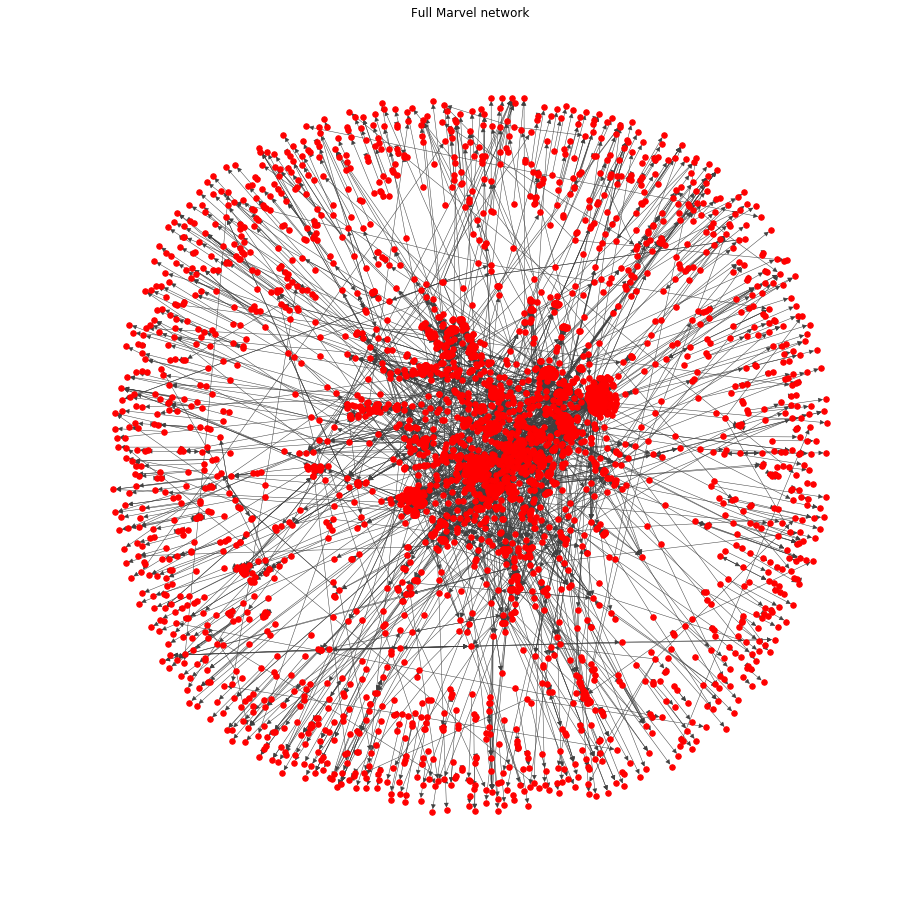

In [46]:
plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, node_size=30, node_color="#FF0000", node_shape='o', edge_color='.25', with_labels=False, width=.5, pos=pos)
plt.title('Full Marvel network')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:28<00:00,  1.10it/s]


('BarnesHut Approximation', ' took ', '23.09', ' seconds')
('Repulsion forces', ' took ', '1018.06', ' seconds')
('Gravitational forces', ' took ', '0.31', ' seconds')
('Attraction forces', ' took ', '0.53', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '1.42', ' seconds')


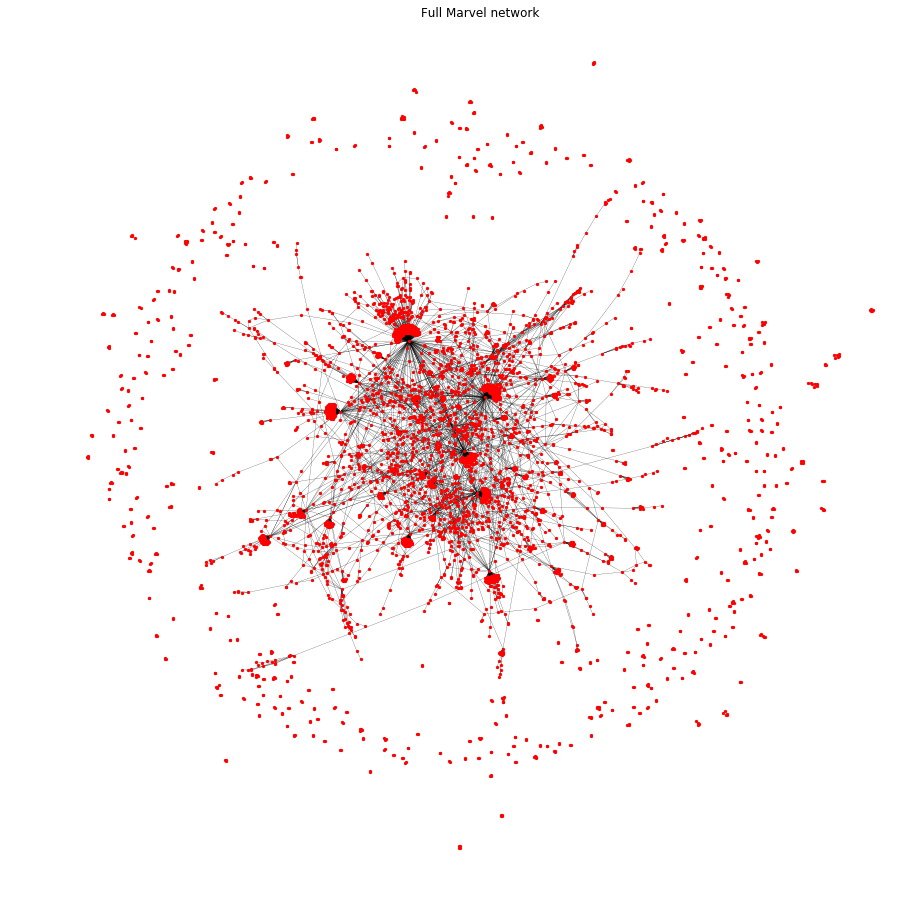

In [29]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.4,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.2,

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=0.1,

                          # Log
                          verbose=True
)
    
positions = forceatlas2.forceatlas2_networkx_layout(U,pos=None, iterations=1000)
#enlarge plot
plt.figure(1, figsize=(12,12))
nx.draw(U, positions, width = 0.2, node_size=5, with_labels=False)
plt.title('Full Marvel network')
plt.axis('off')
plt.show()

## **Step 1: Centrality measures**<br><br>
**What**: We are going to start off the analysis by using centrality measures to discover the most important nodes in the network based on different properties of the graph. <br><br>
**How**: We have used these measures to discover which of the characters have highest importance in the Marvel universe:<br><br>
- Degree centrality ranks a node high if it has high degree, which indicates that there are many paths in the network through this particular node. It will be a different measure depending on whether you look at in-degree or out-degree or total degree. We have used total degree in this case, since we are interested in characters that are both highly referenced but only have reference to many others.
- Betweenness centrality ranks a node based on the number of shortest paths that includes the particular node. This tells something about how the node ties the network together, since it might be more sparse if it wasn't for this node (or more dense if you are looking at a node with low betweenness centrality).
- Eigenvector centrality is a measure that ranks a node higher if it is connected to a node with high eigenvector centrality. This means that nodes are "rewarded" for linking to significant nodes in the network.<br><br>

**Outcome**: Based on these centrality measures, we constructed some network statistics, in which we show the top 10 ranked characters in terms of the three different centrality measures (degree, betweenness, and eigenvector).<br><br>
- The characters with the highest betweenness centrality are most likely the most famous. These have high betweenness centrality as they are referenced most times and thus they might act as a link between different parts of the Marvel universe.
- Eigenvector centrality ranks a node higher if it is connected to a high-degree node than to a low-degree node. This means that nodes with high-degree neighbors will get a higher eigenvector centrality than degree centrality, as degree centrality only takes that number of direct neighbors into account.
- There is a correlation between the pages with high betweenness centrality and high eigenvector centrality (for in degree) as these seem to be quite similar. It makes sense that the correlation is towards in degree and not out degree, since it is more likely that a bunch of characters refer to the same character and not the other way around.

With *printGraphStats()* we print some statistics of the graph such as degree, betweenness centrality and eigenvector centrality.

In [32]:
def printGraphStats(G_wcc, top=10):
    sorted_G_out_deg = sorted(G_wcc.out_degree(), key=operator.itemgetter(1), reverse=True)
    sorted_G_in_deg = sorted(G_wcc.in_degree(), key=operator.itemgetter(1), reverse=True)
    deg_table = PrettyTable(['Character - In degree',' Character - Out degree'])
    
    for i in range(top):
        a = ["%s, %d" % (prettifyName(sorted_G_in_deg[i][0]), sorted_G_in_deg[i][1]),
            "%s, %d" % (prettifyName(sorted_G_out_deg[i][0]), sorted_G_out_deg[i][1])]
        deg_table.add_row(a)
    
    G_bc = nx.betweenness_centrality(G_wcc)
    G_bc_sorted = [(k, G_bc[k]) for k in sorted(G_bc, key=G_bc.get, reverse=True)]

    bc_table = PrettyTable(['Character', 'Betweenness centrality'])
   
    for i in range(top):
        a = [prettifyName(G_bc_sorted[i][0]),
            "%.3f" % G_bc_sorted[i][1]]
        bc_table.add_row(a)

    ec_table = PrettyTable(['Character', 'Eigenvector centrality (In-degree)', 'Eigenvector centrality (Out-degree)'])
    G_ec_in = nx.eigenvector_centrality(G_wcc)
    G_ec_out = nx.eigenvector_centrality(G_wcc.reverse())
    G_ec_in_sorted = [(k, G_ec_in[k]) for k in sorted(G_ec_in, key=G_ec_in.get, reverse=True)]
    G_ec_out_sorted = [(k, G_ec_out[k]) for k in sorted(G_ec_out, key=G_ec_out.get, reverse=True)]    
    
    
    for i in range(top):
        a = [prettifyName(G_ec_in_sorted[i][0]), 
             "%.4f" % G_ec_in_sorted[i][1],
            "%.4f" % G_ec_out_sorted[i][1]
            ]
        ec_table.add_row(a)
    return deg_table, bc_table, ec_table

 - We display Top 5 charachers with highest **In Degree and Out Degree**

* **In Degree**
 * Anthony Stark - Iron man
 * Bruce Banner - Hulk
 * Benjamin Grimm - The Thing from Fantastic 4
 * Charles Xavier - Professor X
 * Carol Danvers - Captain Marvel

* **Out Degree**
 * Bruce Banner - Hulk
 * Charles Xavier - Professor X
 * Anthony Stark - Iron man
 * Alison Blaire - Dazzler
 * Alexander Summers - Havok

In [33]:
top = 5
deg_table, bc_table, ec_table = printGraphStats(G_wcc, top=top)
print "The top %d Marvel characters with highest In and Out degree" %top
print deg_table

The top 5 Marvel characters with highest In and Out degree
+---------------------------------+-----------------------------------+
|      Character - In degree      |       Character - Out degree      |
+---------------------------------+-----------------------------------+
|  Anthony Stark (Earth-616), 342 |    Bruce Banner (Earth-616), 32   |
|  Bruce Banner (Earth-616), 244  |   Charles Xavier (Earth-616), 23  |
| Benjamin Grimm (Earth-616), 159 |   Anthony Stark (Earth-616), 19   |
| Charles Xavier (Earth-616), 138 |   Alison Blaire (Earth-616), 19   |
|  Carol Danvers (Earth-616), 128 | Alexander Summers (Earth-616), 18 |
+---------------------------------+-----------------------------------+


- We display Top 5 charachers with highest **Betweenness Centrality**
 * Bruce Banner - Hulk
 * Anthony Stark - Iron man
 * Charles Xavier - Professor X
 * Alison Blaire - Dazzler
 * Ares - Ares, God of war

In [34]:
print "\nThe top %d Marvel characters with highest Betweenness Centrality:" % top   
print bc_table


The top 5 Marvel characters with highest Betweenness Centrality:
+----------------------------+------------------------+
|         Character          | Betweenness centrality |
+----------------------------+------------------------+
|  Bruce Banner (Earth-616)  |         0.054          |
| Anthony Stark (Earth-616)  |         0.031          |
| Charles Xavier (Earth-616) |         0.025          |
| Alison Blaire (Earth-616)  |         0.016          |
|      Ares (Earth-616)      |         0.015          |
+----------------------------+------------------------+


- We display Top 5 charachers with highest **Eigenvector centrality (In and Out degree)**
 * Bruce Banner - Hulk
 * Charles Xavier - Professor X
 * Carol Danvers - Captain Marvel
 * Anthony Stark - Iron man
 * Alison Blaire - Dazzler

In [35]:
print "\nThe top %d Marvel characters with highest Eigenvector centrality (In and Out degree)" % top
print ec_table


The top 5 Marvel characters with highest Eigenvector centrality (In and Out degree)
+----------------------------+------------------------------------+-------------------------------------+
|         Character          | Eigenvector centrality (In-degree) | Eigenvector centrality (Out-degree) |
+----------------------------+------------------------------------+-------------------------------------+
|  Bruce Banner (Earth-616)  |               0.4432               |                0.2389               |
| Charles Xavier (Earth-616) |               0.3893               |                0.1940               |
| Carol Danvers (Earth-616)  |               0.2590               |                0.1878               |
| Alison Blaire (Earth-616)  |               0.2269               |                0.1746               |
| Anthony Stark (Earth-616)  |               0.2242               |                0.1390               |
+----------------------------+------------------------------------+

## **Step 2: Community detection and modularity**<br><br>
**What**: Thereafter,  as we have grouped characters into nations depending on their nationality, we will examine whether these predefined nations are good communities or not by using community detection and measuring their modularity. Modularity looks into the connections between nodes in the community and based on these, it determines how community-like the communities are. <br><br>
**How**: Based on the detected communities and the calculated modularity values, we computed a confusion matrix to see which communities ressemble the nationality-grouped characters. The confusion matrix itself is not very informative, so we will look at the distribution of its elements instead. The two graphs shows the distribution between the diagonal and non-diagonal elements of the confusion matrix. If the distribution of the diagonal elements is skewed to the right and the distribution of the non-diagonal elements are skewed to the left, this indicates that the communities are well-defined since they do not have many links between them.<br><br>
**Outcome**: The modularity value for each of the communities are not all positive, which means that they are not potential communities. The Louvain algorithm re-affirms this, as too many communities are detected showing the lack of community-like behaviour within the network.

### Modularity
$$M=\sum\limits_{c=1}^{n_c}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2 \right]$$

$n_c$: Number of communities  
$L_c$: The total number of links within the community $C_c$  
$k_c$: The total degree of the nodes in the community $C_c$  
A node's *total degree*, $k_i$ is given by: $k_i=k_i^{in}+k_i^{out}$

In [36]:
def calculateModularity(nations):
    n_c = len(nations)
    m1 = 0; L1 = 0; k1 = 0; L = 0
    for nation, v in nations.iteritems():
        v['L'] = int(); v['k'] = int(); v['M'] = float(0);
        for member in v['members']:
            if type(G.degree(member)) is int:
                v['k'] = v['k'] + (G.degree(member))
            for m in G.edges(member):
                if (m[0] != member and m[0] in v['members']) or (m[1] != member and m[1] in v['members']):
                    v['L'] = v['L'] + 1
    for v in nations.values():
        L = L+ v['k']
    for k,v in nations.iteritems():
        l_c = float(v['L']); k_c = float(v['k'])
        v['M'] = (l_c / L) - (pow((k_c / (2 * L)), 2.0))
    return nations

In [37]:
nation = calculateModularity(getNations(4))

In [38]:
def nationModularityTable(nations):
    mt = PrettyTable(['Nation', 'L_c', 'k_c', 'M_c'])
    for k, v in nations.items():
        mt.add_row([k, v['L'], v['k'], "%.5f" % v['M']])
    return mt

In [39]:
nation = calculateModularity(getNations(10))
print nationModularityTable(nation),'\n'

+-----------------------+------+------+----------+
|         Nation        | L_c  | k_c  |   M_c    |
+-----------------------+------+------+----------+
|        Russians       |  20  | 152  | 0.00180  |
|         Greeks        |  9   |  60  | 0.00083  |
|        Indians        |  4   |  12  | 0.00037  |
|        Japanese       |  18  |  95  | 0.00165  |
|      New_Attilans     |  4   |  13  | 0.00037  |
|       Genoshans       |  8   |  34  | 0.00074  |
|     Hell_citizens     |  3   |  25  | 0.00028  |
|       Atlanteans      |  33  | 106  | 0.00303  |
|       Asgardians      |  58  | 209  | 0.00528  |
|     Kree_Imperials    |  5   |  16  | 0.00046  |
|         French        |  5   |  35  | 0.00046  |
|       Egyptians       |  8   |  56  | 0.00073  |
|       Korbinites      |  17  |  55  | 0.00157  |
|        Germans        |  34  | 142  | 0.00311  |
|    Shi'ar_Imperials   |  29  |  98  | 0.00267  |
|      Australians      |  0   |  3   | -0.00000 |
|        Attilans       |  60  

### Communities

With *printNationsInfo()* function, we print how many communities have been found and how many charachers do they include.

In [19]:
def printNationsInfo(nations):
    sorted_nations = sorted(nations.items(), key=operator.itemgetter(1), reverse=True)
    nation_table = PrettyTable(['Nationality', 'Number of characters'])
    for n in sorted_nations:
        nation_table.add_row([n[0], n[1]['count']])
    return nation_table

In [20]:
print printNationsInfo(nations)

+-------------------------------+----------------------+
|          Nationality          | Number of characters |
+-------------------------------+----------------------+
|           Americans           |         4779         |
|             Alien             |         3194         |
|            British            |         186          |
|            Russians           |         143          |
|           Asgardians          |         116          |
|            Attilans           |         110          |
|            Germans            |         110          |
|           Canadians           |          73          |
|            Japanese           |          67          |
|        Shi'ar_Imperials       |          62          |
|           Atlanteans          |          60          |
|        Skrull_Imperials       |          52          |
|         Negative_Zoner        |          47          |
|            Chinese            |          45          |
|            English           

+-------------------------------+----------------------+


 - Retrieve the communities using the Louvain algorithm, and print the corresponding network.

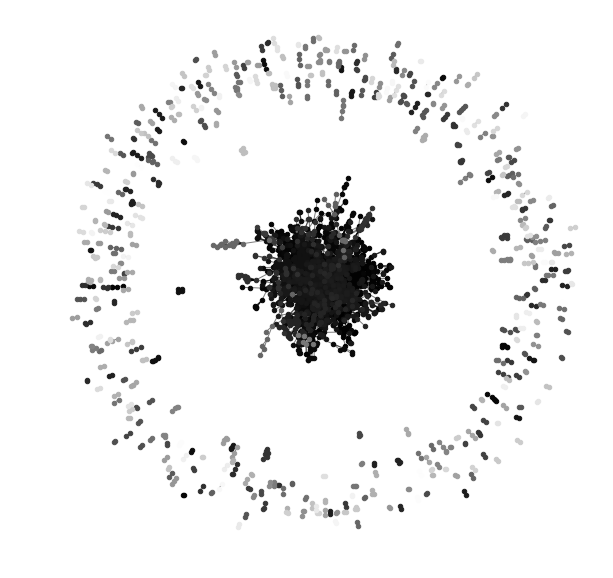

In [40]:
plt.figure(figsize=(10,10))
partition = community.best_partition(U)
size = float(len(set(partition.values())))
pos = nx.spring_layout(U)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(U, pos, list_nodes, node_size = 20, node_color = str(count / size))
nx.draw_networkx_edges(U, pos, alpha=0.5)
plt.axis('off')
plt.show()
 

 - Calculate the confusion matrix.

In [41]:
def calculateConfusionMatrix(U):
    partition = community.best_partition(U)
    nations = getNations(30)
    modularity = community.modularity(partition, U)
    noCommunities = max(partition.values())
    D = np.zeros((len(nations), noCommunities))
    for i in range(len(nations)):
        for j in range(noCommunities):
            for v in partition:
                if partition[v] == j:
                    if v in nations.values()[i]['members']:
                        D[i,j] += 1
    return D, modularity, noCommunities

In [42]:
D, modularity, noCom = calculateConfusionMatrix(U)

In [43]:
print "Confusion matrix:\n", D

Confusion matrix:
[[ 3.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 2.  1. 12. ...  1.  0.  0.]
 ...
 [ 1.  2.  1. ...  0.  0.  0.]
 [21.  2.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


 - Calculate the distribution of the diagonal elements

In [44]:
def confusionMatrixDist(D):
    diag = [D[i,j] for i in range(D.shape[0]) for j in range(D.shape[1]) if i == j]
    a, b = np.histogram(diag)

    plt.figure(1)
    plt.plot(b[:-1], a)
    plt.yticks(range(int(max(a))+1))
    plt.title("Distribution of the diagonal elements")
    plt.show()

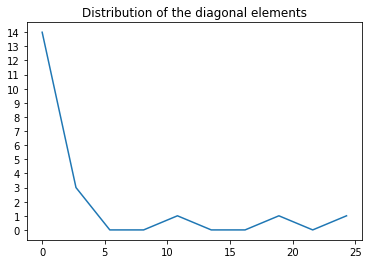

In [45]:
confusionMatrixDist(D)

## Text analysis<br><br>
Based on our network analysis, we detect the characters with the highest total degree and retrieve the transcripts of each movie starring them from the wikia category “Transcripts”and fullmovietext.com. The text goes through a cleaning process, so we can retrieve the relevant information for the sentiment analysis. We use the BeautifulSoup library to get the HTML page. Since we only need a fraction of the page, everything else is filtered out. We scrape the relevant information by looking for a unique class pertaining to the body of the site.

In [2]:
from bs4 import BeautifulSoup
from collections import Counter
import json
import re
import math
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
import operator
import urllib2
from wordcloud import WordCloud
import matplotlib.pylab as plt
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image

In [3]:
# used to clean the html tags when needed
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

### The Avengers

In [4]:
page1 = urllib2.urlopen('http://fullmovietext.com/scenes/1/avengers')
soup1 = BeautifulSoup(page1, 'html.parser')
scenes_urls = soup1.find('table').find_all('a')
scenes_urls = ['http://fullmovietext.com' + scene_url['href'] for scene_url in scenes_urls]
characters_with_transcripts1 = {}

avengers_1_line_count = 0
for scene_url in scenes_urls:
    scene_raw = urllib2.urlopen(scene_url)
    scene_soup = BeautifulSoup(scene_raw, 'html.parser')
    lines = scene_soup.find_all('ul', attrs={'class':'media-list'})[1]
    lines = lines.find_all('li')

    for line in lines:
        if line.find('small'):
            avengers_1_line_count += 1
            key = line.find('small').text
            line.find('small').clear()
            line.find('small').parent.find('div').clear()
            value = line.find('small').parent.text
            if key not in characters_with_transcripts1.keys():
                characters_with_transcripts1[key] = value
            else:
                characters_with_transcripts1[key] += value

characters_with_transcripts1['Steve Rogers'] = characters_with_transcripts1['Captain America']
del characters_with_transcripts1['Captain America']

with open('transcripts_avengers_1.json', 'w') as fp:
    json.dump(characters_with_transcripts1, fp, indent=4)

### Avengers: Age of Ultron

In [5]:
page2 = urllib2.urlopen('http://transcripts.wikia.com/wiki/Avengers:_Age_of_Ultron')
soup2 = BeautifulSoup(page2, 'html.parser')
lines = soup2.find('div', attrs = {'id':'mw-content-text'}).find_all('li')

avengers_2_line_count = 0

characters_with_transcripts2 = {}
for line in lines:
    line = str(line)
    
    if '</b>' in line:
        avengers_2_line_count += 1

        data = line.split('</b>')
        name = striphtml(data[0])
        name = re.sub(r'[\':]','', name).strip()
        transcript = striphtml(data[1])
        transcript = re.sub(r'[\n\\]','', transcript)
        transcript = re.sub(r'\[[^]]*\]', '', transcript)
        if name not in characters_with_transcripts2.keys():
            characters_with_transcripts2[name] = transcript
        else:
            characters_with_transcripts2[name] += ' ' + transcript
            
characters_with_transcripts2['Tony Stark (Ironman)'] = characters_with_transcripts2['Tony Stark']
del characters_with_transcripts2['Tony Stark']

characters_with_transcripts2['Dr. Banner (The Hulk)'] = characters_with_transcripts2['Bruce Banner']
del characters_with_transcripts2['Bruce Banner']

with open('transcripts_avengers_2.json', 'w') as fp:
    json.dump(characters_with_transcripts2, fp, indent=4)

### Avengers: Infinity War

In [6]:
page3 = urllib2.urlopen('http://transcripts.wikia.com/wiki/Avengers:_Infinity_War')
soup3 = BeautifulSoup(page3, 'html.parser')
lines3 = soup3.find('div', attrs={'id':'mw-content-text'}).find_all('p')

avengers_3_line_count = 0

characters_with_transcripts3 = {}
for line in lines3:
    line = str(line)
    line = line.decode('unicode_escape').encode('ascii','ignore')
    
    data = None
    if ':</b>' in line:
        data = line.split(':</b>')
    if '</b>:' in line:
        data = line.split('</b>:')    
    if data:
        avengers_3_line_count += 1

        name = striphtml(data[0])
        name = re.sub(r'[\':]','', name).strip()
        transcript = striphtml(data[1])
        transcript = re.sub(r'\n','', transcript)
        transcript = re.sub(r'\[[^]]*\]', '', transcript)
        if name not in characters_with_transcripts3.keys():
            characters_with_transcripts3[name] = transcript
        else:
            characters_with_transcripts3[name] += ' ' + transcript

characters_with_transcripts3['Tony Stark (Ironman)'] = characters_with_transcripts3['Tony Stark']
del characters_with_transcripts3['Tony Stark']

characters_with_transcripts3['Dr. Banner (The Hulk)'] = characters_with_transcripts3['Bruce Banner']
characters_with_transcripts3['Dr. Banner (The Hulk)'] += characters_with_transcripts3['Hulk']
del characters_with_transcripts3['Bruce Banner']
del characters_with_transcripts3['Hulk']


with open('transcripts_avengers_3.json', 'w') as fp:
    json.dump(characters_with_transcripts3, fp, indent=4)

### Iron Man 2

In [7]:
page_iron_man_2 = urllib2.urlopen('http://transcripts.wikia.com/wiki/Iron_Man_2')
soup_iron_man_2 = BeautifulSoup(page_iron_man_2, 'html.parser')
characters_iron_man_2 = soup_iron_man_2.find('div', attrs = {'id':'mw-content-text'}).find_all('b')
lines_iron_man_2 = soup_iron_man_2.find('div', attrs={'id':'mw-content-text'}).find_all('p')

iron_man_2_line_count = 0

characters_with_transcripts_iron_man_2 = {}
for line in lines_iron_man_2:
    line = str(line)
    line = line.decode('unicode_escape').encode('ascii','ignore')
    
    data = None
    if ':</b>' in line:
        data = line.split(':</b>')
    if '</b>:' in line:
        data = line.split('</b>:')    
    if data:
        iron_man_2_line_count +=1

        name = striphtml(data[0])
        name = re.sub(r'\[[^]]*\]', '', name)
        name = re.sub(r'\([^]]*\)', '', name)
        name = re.sub(r'[\':]','', name).strip()
        
        transcript = striphtml(data[1])
        transcript = re.sub(r'\n','', transcript)
        transcript = re.sub(r'\[[^]]*\]', '', transcript)

        if name not in characters_with_transcripts_iron_man_2.keys():
            characters_with_transcripts_iron_man_2[name] = transcript
        else:
            characters_with_transcripts_iron_man_2[name] += ' ' + transcript

characters_with_transcripts_iron_man_2['Tony Stark (Ironman)'] = characters_with_transcripts_iron_man_2['Tony']
del characters_with_transcripts_iron_man_2['Tony']

with open('transcripts_iron_man_2.json', 'w') as fp:
    json.dump(characters_with_transcripts_iron_man_2, fp, indent=4)

### Iron Man 3

In [8]:
page_iron_man_3 = urllib2.urlopen('http://transcripts.wikia.com/wiki/Iron_Man_3')
soup_iron_man_3 = BeautifulSoup(page_iron_man_3, 'html.parser')
characters_iron_man_3 = soup_iron_man_3.find('div', attrs = {'id':'mw-content-text'}).find_all('b')
lines_iron_man_3 = soup_iron_man_3.find('div', attrs = {'id':'mw-content-text'}).find_all('li')

iron_man_3_line_count = 0

characters_with_transcripts_iron_man_3 = {}
for line in lines_iron_man_3:
    line = str(line)
    
    if '</b>' in line:
        iron_man_3_line_count += 1
        data = line.split('</b>')
        name = striphtml(data[0])
        name = re.sub(r'[\':]','', name).strip()
        transcript = striphtml(data[1])
        transcript = re.sub(r'[\n\\]','', transcript)
        transcript = re.sub(r'\[[^]]*\]', '', transcript)
        transcript = re.sub(r'[\':]','', transcript)
        
        if name not in characters_with_transcripts_iron_man_3.keys():
            characters_with_transcripts_iron_man_3[name] = transcript
        else:
            characters_with_transcripts_iron_man_3[name] += ' ' + transcript
            
characters_with_transcripts_iron_man_3['Tony Stark (Ironman)'] = characters_with_transcripts_iron_man_3['Tony Stark']
del characters_with_transcripts_iron_man_3['Tony Stark']

with open('transcripts_iron_man_3.json', 'w') as fp:
    json.dump(characters_with_transcripts_iron_man_3, fp, indent=4)

### Hulk from Thor: Ragnarok

We used Thor: Ragnarok for Hulk's additional transcripts because we could not get the transcripts from Incredible Hulk. Hulk plays an important role in this movie, so we thought it is relevant enough.

In [9]:
page_hulk = urllib2.urlopen('http://transcripts.wikia.com/wiki/Thor:_Ragnarok')
soup_hulk = BeautifulSoup(page_hulk, 'html.parser')
characters_hulk = soup_hulk.find('div', attrs = {'id':'mw-content-text'}).find_all('b')
lines_hulk = soup_hulk.find('div', attrs={'id':'mw-content-text'}).find_all('p')

hulk_line_count = 0

characters_with_transcripts_hulk = {}
for line in lines_hulk:
    line = str(line)
    line = line.decode('unicode_escape').encode('ascii','ignore')
    
    data = None
    if ':</b>' in line:
        data = line.split(':</b>')
    if '</b>:' in line:
        data = line.split('</b>:')    
    if data:
        hulk_line_count += 1
        name = striphtml(data[0])
        name = re.sub(r'\[[^]]*\]', '', name)
        name = re.sub(r'\([^]]*\)', '', name)
        name = re.sub(r'[\':]','', name).strip()
        
        transcript = striphtml(data[1])
        transcript = re.sub(r'\n','', transcript)
        transcript = re.sub(r'\[[^]]*\]', '', transcript)
        if name not in characters_with_transcripts_hulk.keys():
            characters_with_transcripts_hulk[name] = transcript
        else:
            characters_with_transcripts_hulk[name] += ' ' + transcript

characters_with_transcripts_hulk.keys()
characters_with_transcripts_hulk['Dr. Banner (The Hulk)'] = characters_with_transcripts_hulk['Bruce']
characters_with_transcripts_hulk['Dr. Banner (The Hulk)'] += characters_with_transcripts_hulk['Hulk']
del characters_with_transcripts_hulk['Bruce']
del characters_with_transcripts_hulk['Hulk']
with open('transcripts_hulk.json', 'w') as fp:
    json.dump(characters_with_transcripts_hulk, fp)

Thereafter, the text was tokenized as well as cleaned from stop words and punctuation.

In [10]:
# remove the stopwords and words with less than 4 characters from list of tokens
stop_words = stopwords.words('english')
def clean(tokens):
    return [token for token in tokens if token not in stop_words and len(token) > 3]
# tokenize and clean the text
def tokenize_and_clean(characters_with_transcripts):
    tokenizer = RegexpTokenizer(r"(?=\S*[' ])([a-zA-Z'-]+)")
    tokenized_transcripts = {key: tokenizer.tokenize(line.lower()) for key,line in characters_with_transcripts.items()}
    tokenized_transcripts = {key: clean(tokens) for key, tokens in tokenized_transcripts.items()}
    return tokenized_transcripts

In [11]:
tokenized_transcripts = []
characters_with_transcripts = []

def tokenize_file(filename):
    with open(filename) as json_data:
        tmp = json.load(json_data)
        characters_with_transcripts.append(tmp)
    tokenized_transcripts.append(tokenize_and_clean(tmp))
    
tokenize_file('transcripts_avengers_1.json')
tokenize_file('transcripts_avengers_2.json')
tokenize_file('transcripts_avengers_3.json')
tokenize_file('transcripts_iron_man_2.json')
tokenize_file('transcripts_iron_man_3.json')
tokenize_file('transcripts_hulk.json')

Afterwards, we compute the two character's sentiments according LabMT data in films, in which they star in together:

In [14]:
# read the dataset that contains the list of words with computed sentiments 
# that we use in order to compute the character's sentiments
with open('Data_Set_S1.txt') as f:
    LabMT = f.readlines()
    
words_with_ranks = []
LabMT_words = {}
for line in LabMT[4:]:
    words_with_ranks = line.split()
    LabMT_words[words_with_ranks[0]] = float(words_with_ranks[2])

# compute the sentiment of a list of tokens
def sentiment(tokens):
    frequency_list = FreqDist(tokens)
    sum_frequencies = sum(frequency_list.values())
    normalized_frequency = FreqDist()
    for freq in frequency_list:
        normalized_frequency[freq] = float(frequency_list[freq])/sum_frequencies
        
    hedonometer = 0
    for word in set(tokens):
        if word in LabMT_words:
            hedonometer += LabMT_words[word]*normalized_frequency[word]
    return hedonometer

def get_sentiments(tokenized_transcripts):
    sentiments = {key: sentiment(tokens) for key, tokens in tokenized_transcripts.items()}
    return sentiments

In [15]:
sentiments_avangers_1 = get_sentiments(tokenized_transcripts[0])
sentiments_avangers_2 = get_sentiments(tokenized_transcripts[1])
sentiments_avangers_3 = get_sentiments(tokenized_transcripts[2])

print( "The sentiments of the two characters in the first Avengers movie are:")
print( "Ironman:", sentiments_avangers_1['Tony Stark (Ironman)'], "Hulk:", sentiments_avangers_1['Dr. Banner (The Hulk)'])

print( "The sentiments of the two characters in the second Avengers movie are:")
print( "Ironman:", sentiments_avangers_2['Tony Stark (Ironman)'], "Hulk:", sentiments_avangers_2['Dr. Banner (The Hulk)'])

print( "The sentiments of the two characters in the third Avengers movie are:")
print ("Ironman:", sentiments_avangers_3['Tony Stark (Ironman)'], "Hulk:", sentiments_avangers_3['Dr. Banner (The Hulk)'])

The sentiments of the two characters in the first Avengers movie are:
('Ironman:', 4.553356741573034, 'Hulk:', 4.40736842105263)
The sentiments of the two characters in the second Avengers movie are:
('Ironman:', 4.56485128205128, 'Hulk:', 4.456390977443609)
The sentiments of the two characters in the third Avengers movie are:
('Ironman:', 4.884590818363269, 'Hulk:', 4.461377777777779)


Finally, the text was sent through a TF-IDF process and used to generate the word clouds. 

In [16]:
# create dictionary with two keys, that contains all words for Ironman Hulk, respectively
# this is used for the creation of the wordclouds
tokenized_transcripts_all = {}
tokenized_transcripts_all['Tony Stark (Ironman)'] = tokenized_transcripts[0]['Tony Stark (Ironman)'] + tokenized_transcripts[1]['Tony Stark (Ironman)'] + tokenized_transcripts[2]['Tony Stark (Ironman)'] + tokenized_transcripts[3]['Tony Stark (Ironman)'] + tokenized_transcripts[4]['Tony Stark (Ironman)']
tokenized_transcripts_all['Dr. Banner (The Hulk)'] = tokenized_transcripts[0]['Dr. Banner (The Hulk)']+ tokenized_transcripts[1]['Dr. Banner (The Hulk)'] + tokenized_transcripts[2]['Dr. Banner (The Hulk)'] + tokenized_transcripts[5]['Dr. Banner (The Hulk)']

In [17]:
def computeTF(itemDict, finalItems):
    tfDict = {}
    for word, count in itemDict.items():
        tfDict[word] = count/float(len(finalItems))
    return tfDict

def computeIDF(itemDem, allDocument):
    idfDict = {}
    N = len(itemDem)
    counter = Counter(allDocument)
    counter = dict(counter)
    for word, val in counter.items():
        idfDict[word] = math.log10(N/float(val))
    return idfDict

def TF_IDF(ftFile, idfFile):
    td_idf = {}
    for item, val in ftFile.items():
        if item in idfFile.keys():
            td_idf[item] = val * idfFile[item]
    return td_idf

In [18]:
def get_word_cloud(words, IDF, character, maskname, background_color):
    freq = nltk.FreqDist(words)
    count = dict(freq.most_common()) 
    term_frequency = computeTF(count, words) #Compute TF
    tf_idf = TF_IDF(term_frequency, IDF) #TF_IDF
    
    # create a mask to apply it on the wordcloud so it takes the shape we want
    mask = np.array(Image.open(maskname).convert("RGBA"))
    wc = WordCloud(background_color=background_color, mode="RGBA", mask=mask, random_state=42)

    # generate wordcloud from tf_idf
    wc.generate_from_frequencies(tf_idf)
    
    # take the colors from the image
    image_colors = ImageColorGenerator(mask)
    wc.recolor(color_func=image_colors)
    
    # save wordcloud to file
    wc.to_file(character + '.png')
    
    # plot wordcloud
    fig = plt.figure()
    plt.figure(figsize=(30,18))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")    
    plt.show()

<Figure size 432x288 with 0 Axes>

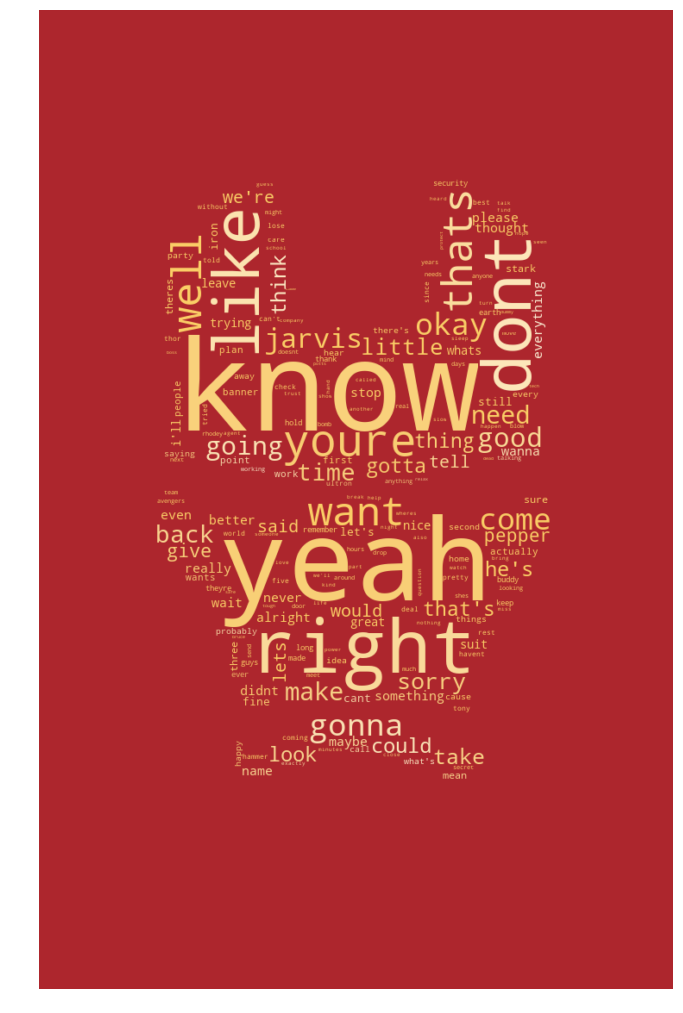

<Figure size 432x288 with 0 Axes>

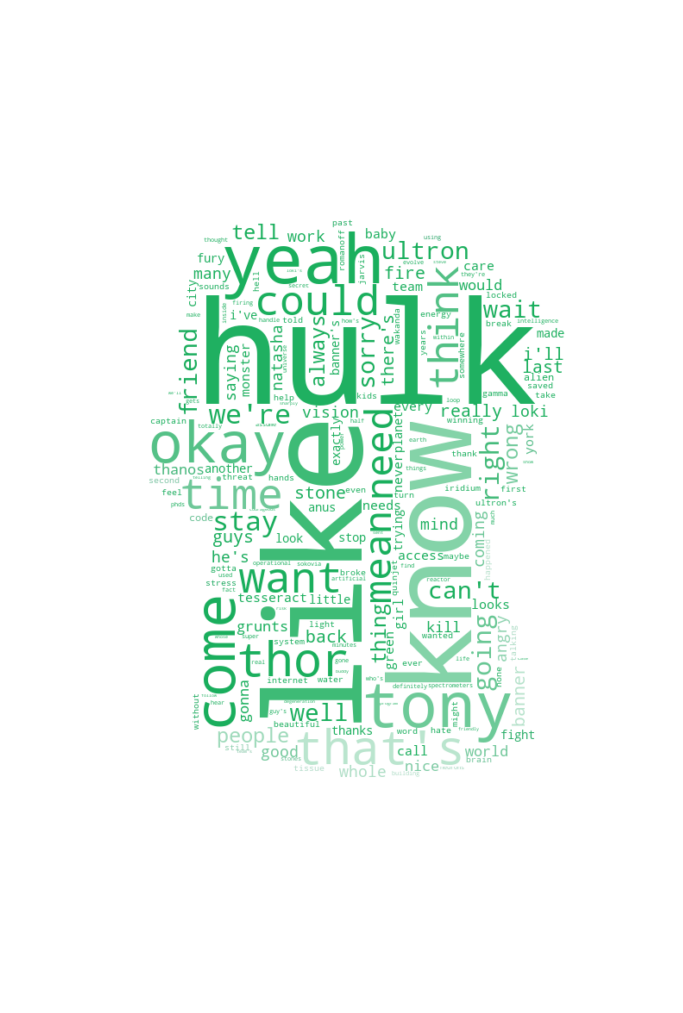

In [20]:
total_freq1 = nltk.FreqDist([token for token in tokenized_transcripts_all['Tony Stark (Ironman)']])
total_count1 = dict(total_freq1)
IDF_Iron_Man = computeIDF(total_count1, [keys for keys in total_freq1.keys()]) #Calculate the IDF

total_freq2 = nltk.FreqDist([token for token in tokenized_transcripts_all['Dr. Banner (The Hulk)']])
total_count2 = dict(total_freq2)
IDF_Hulk = computeIDF(total_count2, [keys for keys in total_freq2.keys()]) #Calculate the IDF

get_word_cloud(tokenized_transcripts_all['Tony Stark (Ironman)'], IDF_Iron_Man, 'Iron Man', 'ironmann.png', '#ad262d')
get_word_cloud(tokenized_transcripts_all['Dr. Banner (The Hulk)'], IDF_Hulk, 'Hulk','hulk_mask.png', 'white')

# VI. Discussion

### What went well?
Overall, it was interesting to put the nationalities of the comic book characters into perspective. Also, we managed to conduct some interesting analysis and visualisations, including interactive networks and word clouds. Furthermore, we have also put a lot of tools from the social graphs and interactions class into use. 

### What is still missing? What could be improved?, Why?
The next step would definitely be to remove the limit on characters and include more than 10.000 characters, so we can get a full overview over the network of comic book characters from the Marvel universe. However, we decided not to do this for this iteration, as we spent a long time debugging decoding and encoding issues related to the already present 10.000 characters. Also, the process to retrieve all the internal links is already very long, so it would take us longer with more characters to examine. This brings us to the next point - an improvement could be to implement a model to process faster the big data set. These changes could have brought up more interesting conclusions with regards to the characters’ nationalities.